[View in Colaboratory](https://colab.research.google.com/github/NoureldinYosri/deep-dive/blob/master/style_transfer.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from keras.models import Model,Sequential
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg19
from keras import backend as K
from scipy.optimize import fmin_l_bfgs_b

import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline
!cat ~/.keras/keras.json
shape = (300,600,3)
hparams = {}
hparams['itr'] = 5
hparams['content_weight'] = 0.04
hparams['style_weight'] = 1
hparams['var_weight'] = 1

Using TensorFlow backend.


{
    "floatx": "float32",
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "image_data_format": "channels_last"
}

In [3]:
!ls gdrive/My\ Drive/Colab\ Notebooks/style_transfer
cwd = 'gdrive/My Drive/Colab Notebooks/style_transfer/'

arts  imgs  style_transfer.ipynb


In [0]:
def load_image(path,to_tensor = False):
  img = load_img(path,target_size=shape)
  if to_tensor:
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
  return img

def deprocess_image(x):
    x = x.reshape(shape)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
content_path = cwd + 'imgs/pyramids.jpg'
style_path = cwd + 'arts/starry_night.jpg'

base = K.variable(load_image(content_path,True))
style = K.variable(load_image(style_path,True))
comb = K.placeholder((1,) + shape)
input_tensor = K.concatenate([base,style,comb],axis = 0)

In [6]:
model = vgg19.VGG19(input_tensor=input_tensor,weights='imagenet',include_top = False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [7]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict)

{'input_1': <tf.Tensor 'concat:0' shape=(3, 300, 600, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 300, 600, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 300, 600, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 150, 300, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 150, 300, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 150, 300, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 75, 150, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 75, 150, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 75, 150, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 75, 150, 256) dtype=float32>, 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 75, 150, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'block3

In [0]:
def gram(x):
    F = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(F, K.transpose(F))
    return gram
  
def style_loss(x,a):
    X = gram(x)
    A = gram(a)
    size = reduce(lambda a,b:a*b,x.shape.as_list())
    return K.sum(K.square(X - A)) / (4 * size**2)

def content_loss(x, p):
  return K.sum(K.square(x - p))

def var_loss(x):
    a = K.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
    b = K.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
p = layer_features[0, :, :, :]
x = layer_features[2, :, :, :]
loss = loss + hparams['content_weight'] * content_loss(x, p)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    a = layer_features[1, :, :, :]
    x = layer_features[2, :, :, :]
    tmp = style_loss(x,a)
    loss = loss + (hparams['style_weight'] / len(feature_layers)) * tmp
    
loss = loss + hparams['var_weight'] * var_loss(comb)
grads = K.gradients(loss, comb)
outs = [loss]
if isinstance(grads, (list, tuple)):
    outs += grads
else:
    outs.append(grads)

func = K.function([comb],outs)

In [0]:
def eval_loss_and_grads(x):
    x = x.reshape((1,) + shape)
    outs = func([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

Current loss value: 2690201600.0


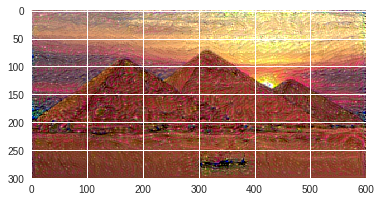

Current loss value: 1844981500.0


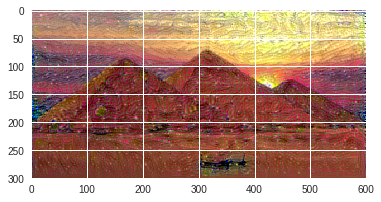

Current loss value: 1562682100.0


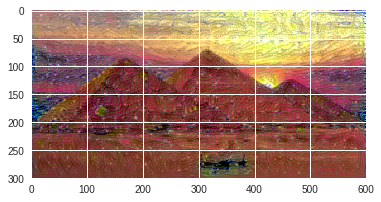

Current loss value: 1399409900.0


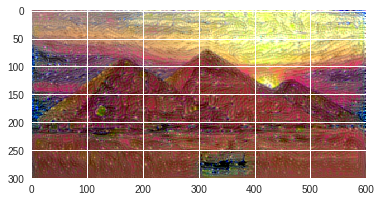

Current loss value: 1297705700.0


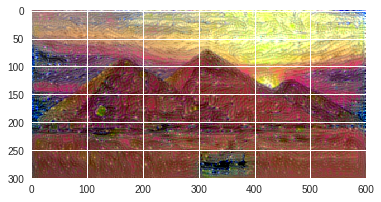

In [10]:
evaluator = Evaluator()
x = load_image(content_path,True)

for i in range(hparams['itr']):
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    img = deprocess_image(x.copy())
    plt.imshow(img)
    plt.show()

In [0]:
import scipy.misc
scipy.misc.imsave('img.jpg', img)

In [0]:
from google.colab import files
files.download( "img.jpg" ) 